In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#读取数据
data_dict = {}
os.chdir('/content/drive/MyDrive/m5-forecasting-accuracy')
for file in os.listdir():
  data_dict[file[:-4]] = pd.read_csv('/content/drive/MyDrive/m5-forecasting-accuracy/'+file)

In [3]:
data_dict.keys()

dict_keys(['calendar', 'sales_train_evaluation', 'sales_train_validation', 'sample_submission', 'sell_prices', 'submission'])

In [4]:
def event_detector(x):
    if x == None:
        return 0
    else:
        return 1

In [5]:
#处理数据
df1 = data_dict['sales_train_evaluation'].drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1).set_index('id').T
df1['d'] = df1.index
df2 = data_dict['calendar']
df = pd.merge(df2, df1, left_on='d', right_on='d', how='left')

drp = ['wm_yr_wk', 'weekday', 'year', 'd', 'event_type_1', 'event_type_2']

cols_x = ['wday', 'month', 'event_name_1', 'event_name_2','snap_CA', 'snap_TX', 'snap_WI']

df = df.drop(drp, axis=1)
df['event_name_1'] = df['event_name_1'].apply(lambda x: event_detector(x))
df['event_name_2'] = df['event_name_2'].apply(lambda x: event_detector(x))
df

,date,wday,month,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_011_CA_1_evaluation,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_013_CA_1_evaluation,HOBBIES_1_014_CA_1_evaluation,HOBBIES_1_015_CA_1_evaluation,HOBBIES_1_016_CA_1_evaluation,HOBBIES_1_017_CA_1_evaluation,HOBBIES_1_018_CA_1_evaluation,HOBBIES_1_019_CA_1_evaluation,HOBBIES_1_020_CA_1_evaluation,HOBBIES_1_021_CA_1_evaluation,HOBBIES_1_022_CA_1_evaluation,HOBBIES_1_023_CA_1_evaluation,HOBBIES_1_024_CA_1_evaluation,HOBBIES_1_025_CA_1_evaluation,HOBBIES_1_026_CA_1_evaluation,HOBBIES_1_027_CA_1_evaluation,HOBBIES_1_028_CA_1_evaluation,HOBBIES_1_029_CA_1_evaluation,HOBBIES_1_030_CA_1_evaluation,HOBBIES_1_031_CA_1_evaluation,HOBBIES_1_032_CA_1_evaluation,...,FOODS_3_788_WI_3_evaluation,FOODS_3_789_WI_3_evaluation,FOODS_3_790_WI_3_evaluation,FOODS_3_791_WI_3_evaluation,FOODS_3_792_WI_3_evaluation,FOODS_3_793_WI_3_evaluation,FOODS_3_794_WI_3_evaluation,FOODS_3_795_WI_3_evaluation,FOODS_3_796_WI_3_evaluation,FOODS_3_797_WI_3_evaluation,FOODS_3_798_WI_3_evaluation,FOODS_3_799_WI_3_evaluation,FOODS_3_800_WI_3_evaluation,FOODS_3_801_WI_3_evaluation,FOODS_3_802_WI_3_evaluation,FOODS_3_803_WI_3_evaluation,FOODS_3_804_WI_3_evaluation,FOODS_3_805_WI_3_evaluation,FOODS_3_806_WI_3_evaluation,FOODS_3_807_WI_3_evaluation,FOODS_3_808_WI_3_evaluation,FOODS_3_809_WI_3_evaluation,FOODS_3_810_WI_3_evaluation,FOODS_3_811_WI_3_evaluation,FOODS_3_812_WI_3_evaluation,FOODS_3_813_WI_3_evaluation,FOODS_3_814_WI_3_evaluation,FOODS_3_815_WI_3_evaluation,FOODS_3_816_WI_3_evaluation,FOODS_3_817_WI_3_evaluation,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
0,2011-01-29,1,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,16.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,14.0,0.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-30,2,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,4.0,0.0,0.0,6.0,0.0,0.0
2,2011-01-31,3,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,6.0,0.0,0.0,9.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
3,2011-02-01,4,2,1,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,11.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0,0.0,5.0,2.0,0.0,2.0,0.0,0.0
4,2011-02-02,5,2,1,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [6]:
ddf = df[(pd.to_datetime(df['date']) < '2016-04-25')&(pd.to_datetime(df['date']) >= '2015-06-19')].drop('date', axis=1)
valid_df = df[(pd.to_datetime(df['date']) >= '2016-04-25')&(pd.to_datetime(df['date']) < '2016-05-23')].drop('date', axis=1)
eval_df = df[pd.to_datetime(df['date']) >= '2016-05-23'].drop('date', axis=1)

X_ddf = ddf[cols_x]
y_ddf = ddf.drop(cols_x, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_ddf, y_ddf, test_size=0.33, random_state=42)

In [7]:
#定义损失函数
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

In [8]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard
import keras.backend as K

EarlyStop = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=20,
      verbose=1,
      min_delta=0.001, 
      mode='min')


epochs = 1000
batch_size = 96
verbose = 1
validation_split = 0.2
input_dim = X_train.shape[1]
n_out = y_train.shape[1]

model = Sequential([
                Dense(512, input_shape=(input_dim,)),
                Activation('relu'),
                Dropout(0.2),
                Dense(512),
                Activation('relu'),
                Dropout(0.2),
                Dense(n_out),
                Activation('relu'),
                    ])

model.compile(loss= rmse, optimizer='adam')

hist = model.fit(X_train, y_train,
                         batch_size = batch_size, epochs = epochs,
                         callbacks = [EarlyStop],
                         verbose=verbose, validation_split=validation_split)

#model.save('/content/drive/MyDrive/m5-forecasting-accuracy/NN_model.h5')

Epoch 1/1000
2/2 [==============================] - 1s 358ms/step - loss: 3.8393 - val_loss: 3.7948
Epoch 2/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.7855 - val_loss: 3.6930
Epoch 3/1000
2/2 [==============================] - 0s 64ms/step - loss: 3.6761 - val_loss: 3.5464
Epoch 4/1000
2/2 [==============================] - 0s 67ms/step - loss: 3.5273 - val_loss: 3.4006
Epoch 5/1000
2/2 [==============================] - 0s 66ms/step - loss: 3.3810 - val_loss: 3.2879
Epoch 6/1000
2/2 [==============================] - 0s 65ms/step - loss: 3.2563 - val_loss: 3.1980
Epoch 7/1000
2/2 [==============================] - 0s 62ms/step - loss: 3.1621 - val_loss: 3.1070
Epoch 8/1000
2/2 [==============================] - 0s 63ms/step - loss: 3.0673 - val_loss: 3.0105
Epoch 9/1000
2/2 [==============================] - 0s 60ms/step - loss: 2.9773 - val_loss: 2.9284
Epoch 10/1000
2/2 [==============================] - 0s 62ms/step - loss: 2.9095 - val_loss: 2.8657
Epoch 11

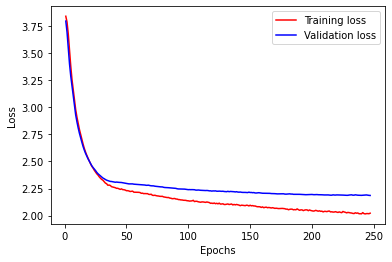

In [9]:
plt.clf()
plt.figsize=(40, 25)
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) +1)

plt.plot(epochs, loss, 'b', label = 'Training loss',color = 'r')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
X_valid = valid_df[cols_x]
X_eval = eval_df[cols_x]

ss = data_dict['sample_submission']

pred_valid = pd.DataFrame(model.predict(X_valid), columns = ss[0:int(len(ss)/2)].set_index('id').T.columns)
pred_eval = pd.DataFrame(model.predict(X_eval), columns = ss[int(len(ss)/2):].set_index('id').T.columns)
ss_valid =  pred_valid.T
ss_eval = pred_eval.T

submission_df = pd.concat([ss_valid, ss_eval]).reset_index()
submission_df.columns = ss.columns

submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.882852,0.883404,0.906734,0.965660,1.030863,1.353112,1.013619,0.754381,0.677510,0.765201,0.603323,0.645667,1.450248,0.972972,0.891750,0.736038,0.586668,0.635324,0.949122,1.282641,1.001811,0.840110,0.834444,0.867159,0.920973,0.992079,1.277472,0.922196
1,HOBBIES_1_002_CA_1_validation,0.327205,0.342247,0.411472,0.486075,0.555770,0.556125,0.282405,0.515612,0.528877,0.320919,0.484279,0.508634,0.504743,0.709371,0.742902,0.223684,0.526263,0.585219,0.638238,0.784127,0.690557,0.394831,0.497364,0.608951,0.686712,0.759799,0.642295,0.499107
2,HOBBIES_1_003_CA_1_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.299995,0.000000,0.000000,0.000000,0.000000,0.027483,0.199899,0.160746,0.000000,0.000000,0.000000,0.342230,0.510644,0.422458,0.017932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267327,0.000000
3,HOBBIES_1_004_CA_1_validation,1.768188,1.233921,1.117591,1.123732,1.163456,3.521768,2.464450,1.839779,1.226836,1.053251,1.071145,1.096575,3.144380,2.566613,1.779567,1.179215,1.065317,1.047687,1.024552,3.280403,2.372066,1.715334,1.185975,1.082699,1.091588,1.136660,3.485560,2.680799
4,HOBBIES_1_005_CA_1_validation,0.964727,0.995282,0.922504,0.866243,0.838720,1.061406,1.475481,1.247030,1.129877,1.242586,1.115322,1.127784,1.491387,1.292150,1.205445,1.302927,0.990734,0.961181,0.993807,1.176388,1.220797,0.935054,0.982989,0.958394,0.913154,0.889709,1.062267,0.992664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.081084,0.167009,0.240150,0.303558,0.000000,0.000000,0.000000,0.081084,0.499526,0.118685,0.349957,0.000000,0.572113,0.654688,0.544765,0.072351,0.323432,0.417721,0.000000,0.294781,0.477182,0.000000,0.255142,0.313672,0.368899,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.097386,0.036381,0.077241,0.132614,0.184259,0.530534,0.313685,0.097386,0.036381,0.616125,0.520373,1.168781,0.131973,0.215663,0.456453,0.529421,0.419332,1.088799,0.140158,0.202391,0.170929,0.261774,0.095879,0.733425,0.000000,0.000000,0.238573,0.022605
60978,FOODS_3_826_WI_3_evaluation,1.146249,0.893297,0.739623,0.637482,0.581329,0.682846,1.162430,1.146249,0.893297,0.525145,0.500764,0.141093,1.214425,2.091552,1.561666,0.734127,0.689561,0.273951,0.651746,1.305716,1.560868,0.855260,0.773015,0.225109,0.669899,0.600177,0.609814,1.129621


In [11]:
submission_df.to_csv('/content/drive/MyDrive/m5-forecasting-accuracy/submission.csv', index=False)